# Construct synthetic sequences and look at how the core CTCF motif interacts with the TA motif

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_peak_table

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader

import random
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.dpi"] = 130

### a) Generate a set of 100 random sequence backgrounds

In [2]:
# set seed for reproducibility
rng = np.random.default_rng(2022)

In [3]:
# generate random sequence backgrounds
seqs = []
alphabet = ['A','C','G','T']

for i in range(100):
    seqs.append(''. join(rng.choice(alphabet) for _ in range(2114)))

### b) Insert the core motif and the TA motif in the center of the sequences, and pass them through the model, averaging the prediction over all 100 sequences

In [142]:
core_motif = 'TGACGTCA'
ta_motif = 'TA'

In [147]:
# load in model
controls = True
model = ModelLoader('/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_feb7/' + 'model.state_dict', controls=controls, num_tasks=1).load_model()

In [112]:
def avg_preds_at_distance(distance, seqs, model, core='moving', TA='moving'):
    ''' given a distance between core motif and TA motif, along with 100 random background seqs
        and a model, insert motifs at appropriate distance in each seq, then calculate predictions 
        for each seq, then average predictions across all 100 seqs
        
        update july 2, 2022: 
        new params `core` and `TA` allow you to NOT include the TA motif, and only examine how the profile changes 
        as the core motif moves around as a control; or alternatively to hold the core motif still and move the TA motif 
        valid values:
            `core` in ['moving', 'static']
            `TA` in ['moving', None]
            
        update july 8, 2022:
            now also returns TA binding profile strength if TA == 'moving'
    '''
    core_insertion_index = 2114 // 2 - 10 - distance // 2 #  - 10 can change to something else
    ta_insertion_index = core_insertion_index + len(core_motif) + distance
    
    original_seqs = seqs.copy()  # just to be careful with memory and overriding stuff
    # insert motifs 
    for i in range(len(original_seqs)):
        seq = original_seqs[i]
        assert seq.count(core_motif) < 5
        if core == 'moving' and TA == 'moving':
            original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):ta_insertion_index] + \
            ta_motif + seq[ta_insertion_index + len(ta_motif):]
        elif core == 'moving' and TA == None:
            original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):]  # only insert core motif
        elif core == 'static' and TA == 'moving':
            core_insertion_index = 2114 // 2 - 10
            original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):ta_insertion_index] + \
            ta_motif + seq[ta_insertion_index + len(ta_motif):]
        else:
            print('error in `core` and `TA` parameters')
            return

    original_seqs = dna_to_one_hot(original_seqs)   # so you end up with one-hot encoded seqs
    original_seqs = torch.from_numpy(original_seqs).float()
    original_seqs = original_seqs.cuda(device=device, non_blocking=True)
    
    # get predictions
    with torch.no_grad():
        if controls:
            cont_profs = torch.zeros((100, 1, 1000, 2)).cuda()  # CHANGE THIS IF MORE THAN 1 TASK, other issues etc.
            logit_pred_profs, log_pred_counts = model(original_seqs, cont_profs)
        else:
            logit_pred_profs, log_pred_counts = model(original_seqs)
    logit_pred_profs = logit_pred_profs.detach().cpu().numpy()  # go back to cpu
    log_pred_counts = log_pred_counts.detach().cpu().numpy()
    log_pred_profs = profile_logits_to_log_probs(logit_pred_profs)
    
    # average across all 100 seqs; THESE ARE ALREADY EXPONENTIATED, NO LOG!! also removes the 1st dimension!!
    avg_pred_profs = np.mean(np.exp(log_pred_profs), axis=0) 
    avg_pred_counts = np.mean(np.exp(log_pred_counts), axis=0) 
    
    log_pred_counts_reshaped = np.repeat(log_pred_counts[:, :, np.newaxis, :], 1000, axis=2)  # same shape as log_pred_profs now
    avg_pred_profs_times_counts = np.mean(np.exp(log_pred_profs) * np.exp(log_pred_counts_reshaped), axis=0) 

    TA_binding_strength = None
    if TA == 'moving':
        TA_binding_strength = np.sum(avg_pred_profs_times_counts[0][ta_insertion_index - (2114//2-500) - 3 : ta_insertion_index - (2114//2-500) + 3],
                                     axis=0)
            
    return avg_pred_profs_times_counts, TA_binding_strength

In [122]:
def plot_TA_binding_strength(TA_binding_strengths):
    ''' TA_binding_strengths is a list of length 100 from running avg_preds_at_distance over 100 distances (100 times) ''' 
    # plot TA binding strength at each distance from core motif
    plt.plot(list(range(0,1000,10)), list(i[0] for i in TA_binding_strengths), color='royalblue',label='Positive strand')
    plt.plot(list(range(0,1000,10)), list(i[1] for i in TA_binding_strengths), color='goldenrod',label='Negative strand') 
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around TA motif')
    plt.title('TA binding strength at various distances from core motif')
    plt.legend()
    plt.show()
    
    
def plot_TA_binding_strength_with_controls(TA_binding_strengths, TA_binding_strength_controls):
    ''' both inputs are a list of length 100 from running avg_preds_at_distance over 100 distances (100 times) ''' 
    # plot TA binding strength at each distance from core motif
    plt.plot(list(range(0,1000,10)), list(i[0] for i in TA_binding_strengths), color='royalblue',label='Positive strand')
    plt.plot(list(range(0,1000,10)), list(i[1] for i in TA_binding_strengths), color='goldenrod',label='Negative strand') 
    plt.plot(list(range(0,1000,10)), list(i[0] for i in TA_binding_strength_controls), 
             color="chartreuse", alpha=0.7, label='Positive strand with ONLY TA motif moving')
    plt.plot(list(range(0,1000,10)), list(i[1] for i in TA_binding_strength_controls), 
             color="tomato", alpha=0.7, label='Negative strand with ONLY TA motif moving') 
            
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around TA motif')
    plt.title('TA binding strength at various distances from core motif')
    plt.legend()
    plt.show()

### c) Vary the distance between the CTCF motif and the TA motif. How does the profile shape change as the distance changes (show animation)?

In [148]:
all_avg_pred_profs_times_counts, TA_binding_strengths = [], []
for distance in range(0,1000,10):
    avg_pred_profs_times_counts, TA_binding_strength = avg_preds_at_distance(distance, seqs, model)
    all_avg_pred_profs_times_counts.append(avg_pred_profs_times_counts)
    TA_binding_strengths.append(TA_binding_strength)

In [149]:
all_avg_pred_profs_times_counts_control, TA_binding_strength_controls = [], []
for distance in range(0,1000,10):
    avg_pred_profs_times_counts_control, TA_binding_strength_control = avg_preds_at_distance(distance, seqs, model, core='static', TA='moving')
    all_avg_pred_profs_times_counts_control.append(avg_pred_profs_times_counts_control)
    TA_binding_strength_controls.append(TA_binding_strength_control)

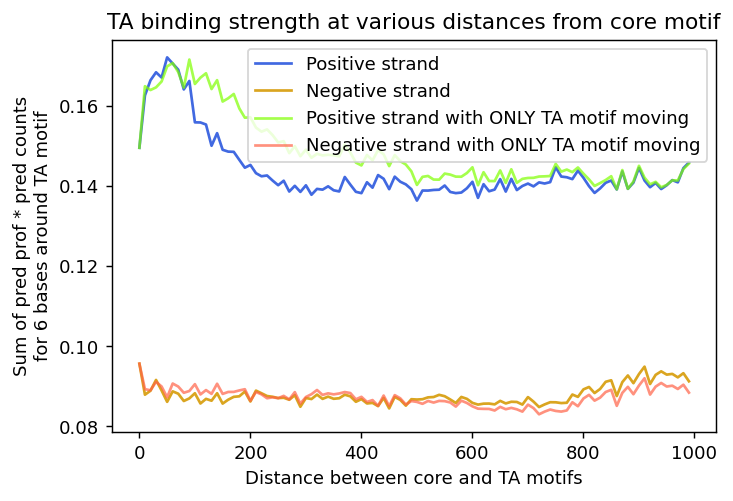

In [150]:
plot_TA_binding_strength_with_controls(TA_binding_strengths, TA_binding_strength_controls)

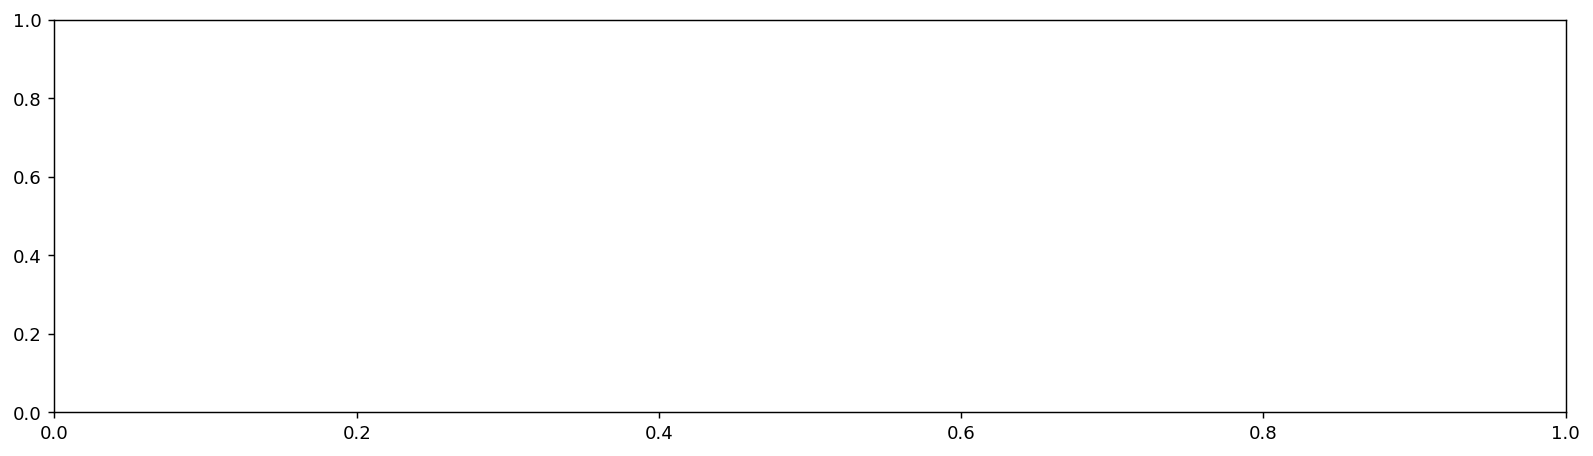

In [55]:
# new version, where profs are proportional to counts
fig, ax = plt.subplots(1, figsize=(15, 4))
upper_lim = np.max(list(np.max(all_avg_pred_profs_times_counts[i]) for i in range(100))) + 0.1  # so graphs look nice

def animate(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))
    
def animate_with_core_no_TA(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    pred_profs_control = all_avg_pred_profs_times_counts_control[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue", label='Positive strand with TA motif')
    ax.plot(-pred_profs[0,:,1], color="goldenrod", label='Negative strand with TA motif')
    ax.plot(pred_profs_control[0,:,0], color="chartreuse", alpha=0.5, label='Positive strand without TA motif (control)')
    ax.plot(-pred_profs_control[0,:,1], color="tomato", alpha=0.5, label='Negative strand without TA motif (control)')
    ax.legend()
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))
    
def animate_with_static_core_moving_TA(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    pred_profs_control = all_avg_pred_profs_times_counts_control[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue", label='Positive strand with core and TA motifs moving')
    ax.plot(-pred_profs[0,:,1], color="goldenrod", label='Negative strand with core and TA motifs moving')
    ax.plot(pred_profs_control[0,:,0], color="chartreuse", alpha=0.7, label='Positive strand with ONLY TA motif moving')
    ax.plot(-pred_profs_control[0,:,1], color="tomato", alpha=0.7, label='Negative strand with ONLY TA motif moving')
    ax.legend()
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between moving core and TA motifs: ' + str(i * 10))

anim = FuncAnimation(fig, animate_with_static_core_moving_TA, frames=100)

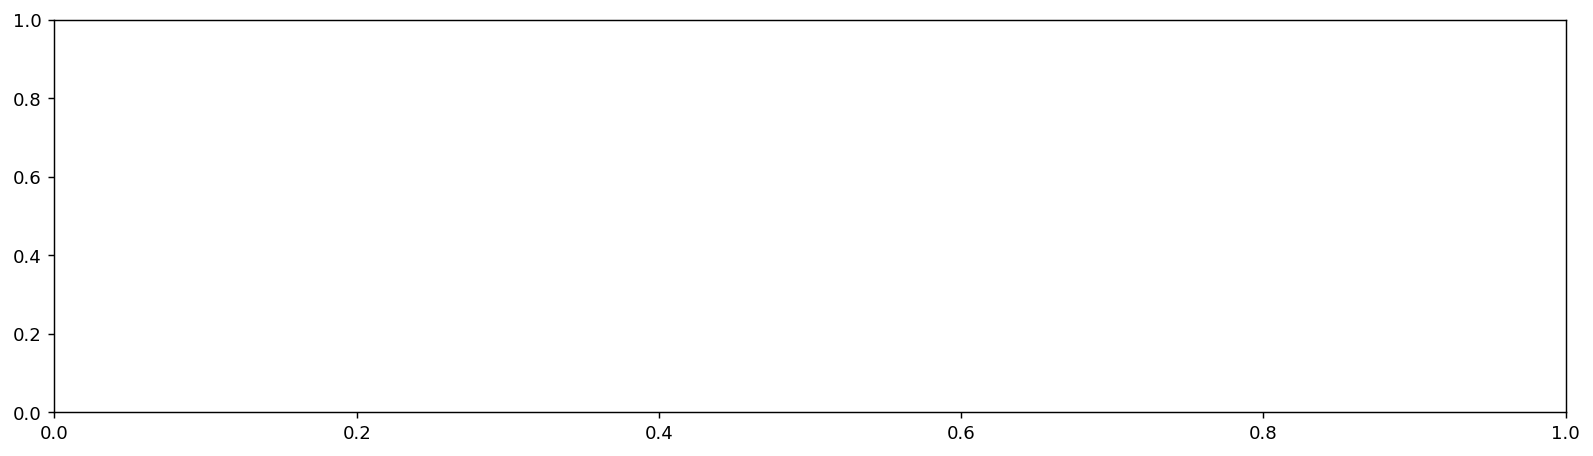

In [59]:
# old version, where profs and counts are split
fig, ax = plt.subplots(1, figsize=(15, 4))
upper_lim = np.max(list(np.max(all_avg_pred_profs[i] * all_avg_pred_counts[i]) for i in range(100))) + 0.1  # so graphs look nice

def animate(i):
    plt.clf()
    avg_pred_profs = all_avg_pred_profs[i]
    avg_pred_counts = all_avg_pred_counts[i]
    
    pred_profs = avg_pred_profs * avg_pred_counts
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))

anim = FuncAnimation(fig, animate, frames=100)

In [57]:
anim.save('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_3/ctcf_cutnrun_static_core_moving_TA.mp4')

<Figure size 780x520 with 0 Axes>

In [56]:
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

### e) How do the total counts change as the distance changes?
would need to rewrite this bc doesn't work now that i took out all_avg_pred_counts :/

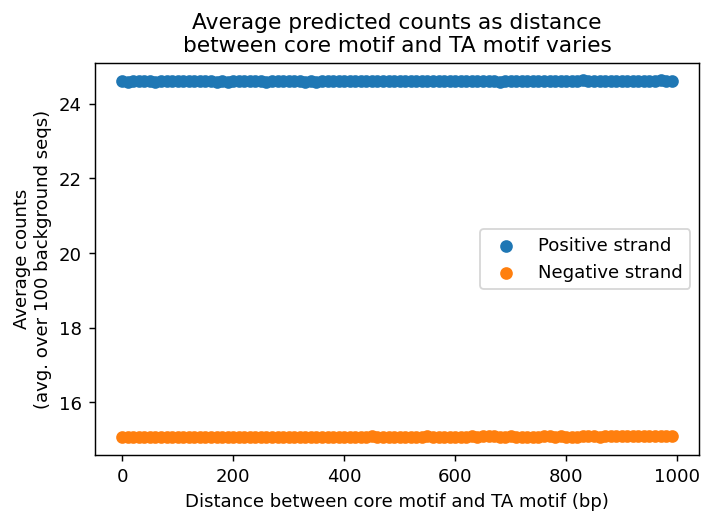

In [65]:
fig, ax = plt.subplots()
ax.scatter(list(i * 10 for i in range(100)), list(i[0][0] for i in all_avg_pred_counts), label='Positive strand')
ax.scatter(list(i * 10 for i in range(100)), list(i[0][1] for i in all_avg_pred_counts), label='Negative strand')

plt.xlabel('Distance between core motif and TA motif (bp)')
plt.ylabel('Average counts\n(avg. over 100 background seqs)')
plt.title('Average predicted counts as distance\nbetween core motif and TA motif varies')

ax.legend()